In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/MDS.py

In [19]:
protein_name = 'cdk2'

In [20]:
path_to_file = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json'
df_prot = pd.read_json(path_to_file)

In [21]:
df_dims = pd.read_pickle('../9_Dash_App_Preprocessing/CDK2_DIMS_reduced_TABLE_dashApp.obj')
# update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

In [22]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl')

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']

# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

In [23]:
# *******************
# Pocket Residues 
# *******************
dir_volumen_results = f'./pocket_info/{protein_name}/'

vol_tan_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix.csv', header=None)
vol_tan_col_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix_colored.csv', header=None)
vol_tan_hyfb_mtx = pd.read_csv(dir_volumen_results +'POVME_Tanimoto_matrix_hydrophobic.csv', header=None)

# MDS using only col Tanimoto
mds_vol_pkt = cMDS(1 - vol_tan_mtx)[0]
# update the df with the mds axis
df_prot['x'] = mds_vol_pkt[0]
df_prot['y'] = mds_vol_pkt[1]

In [24]:
# Open RFE_estimator
# filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': df_prot.index, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')
df_ranks = df_ranks.set_index('pdb_id')

# update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

In [25]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume.T'] = (df_prot['volume']/100) ** 1.5

In [26]:
df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'vol_x'
y = 'vol_y'
size='volume.T'

# fig, ax = plt.subplots(figsize=(8,8), dpi=200)
# sns.scatterplot(x=x, y=y, data=df_prot, size=size)
# sns.scatterplot(x=x, y=y, data=df_selected, size=size)
# plt.show()

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
df_to_R = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]

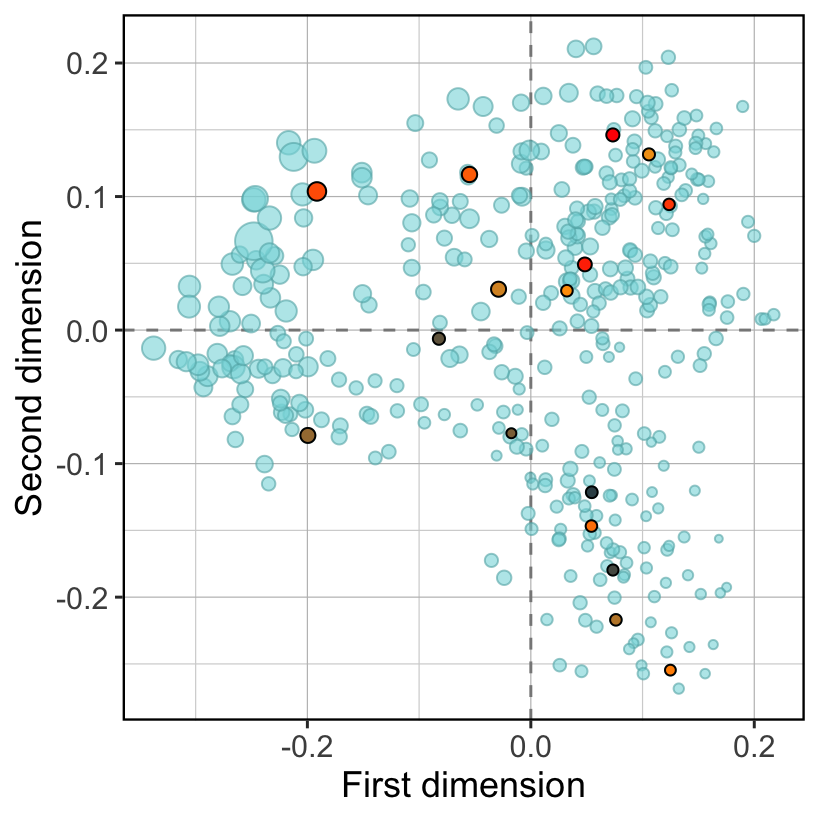

In [29]:
%%R -i df_to_R -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=vol_x, y=vol_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

protein_name <- 'cdk2'
methodology <- 'mds_plot'
filename <- paste0('images/cdk2/', paste(protein_name, methodology,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

## Swarplot with the auc values

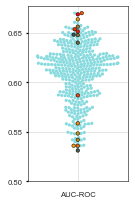

In [30]:
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=["red", "orange", "#374E55"],
    N=16
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale=0.7, style='whitegrid')

df_ = df_prot.copy()
df_['top_mask'] = [3 if i <= 4 else 2 if i <= 16 else 1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']].melt(id_vars=('top_mask', 'rfe_ranking'))

fig, ax = plt.subplots(figsize=(1.8, 3.22))
# fig, ax = plt.subplots(figsize=(4.1, 6.2))
# Blue dots
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=3.2,
              data=df_, ax=ax,
              color='#87DADE')
# top 16
df_top = df_.query('top_mask > 1') 
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=3.5,
              data=df_top, ax=ax,
              hue='rfe_ranking',
              edgecolor='black', linewidth=0.5,
              palette='mycolormap')
# ax.set_ylim((0.49, 0.7))
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length=2, color='black', axis='y')
ax.grid(True, linewidth=0.5)
ax.set(xlabel='', ylabel='')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.savefig('./images/cdk2/swarm_plot_confs.pdf') 
plt.show()

## MDS using Secondary structure

In [41]:
df_to_R_sec = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]

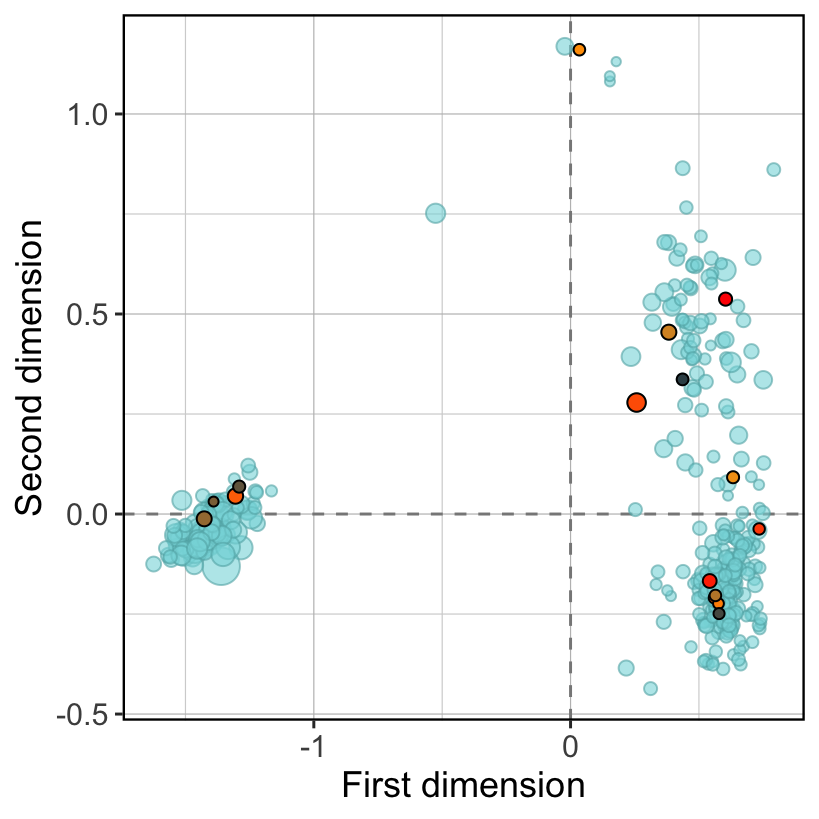

In [42]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=secres_x, y=secres_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=secres_x, y=secres_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')


protein_name <- 'cdk2'
methodology <- 'mds_plot'
selection <- 'secstruct'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, selection,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

## MDS using pocket residues

In [43]:
df_to_R_sec = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]

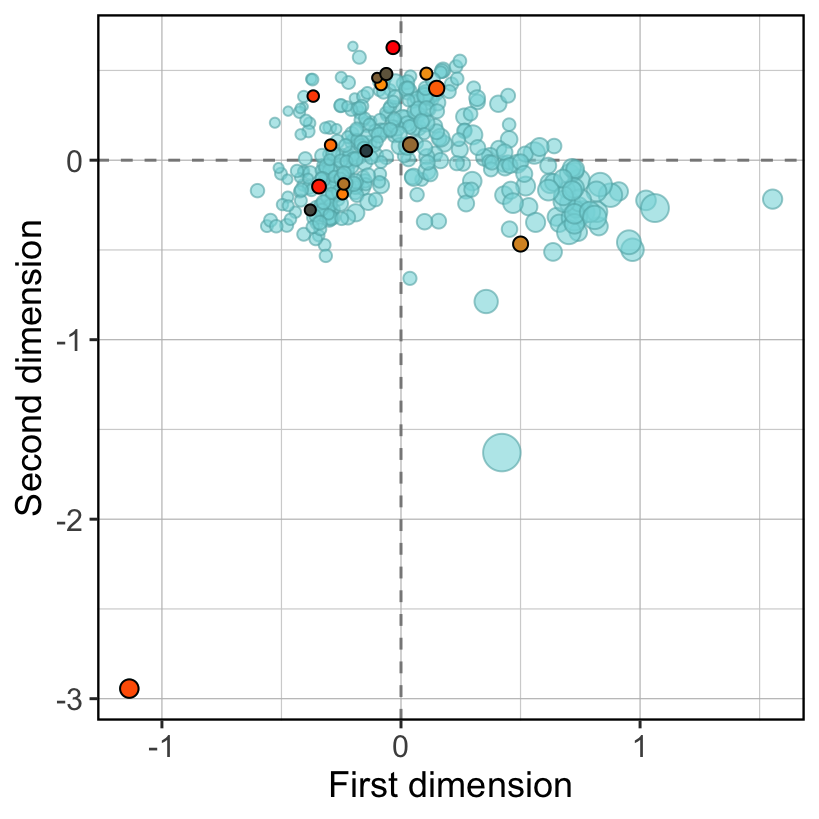

In [44]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=pkt_x, y=pkt_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=pkt_x, y=pkt_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')


protein_name <- 'cdk2'
methodology <- 'mds_plot'
selection <- 'pocket_rmsd'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, selection,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

### Testing area

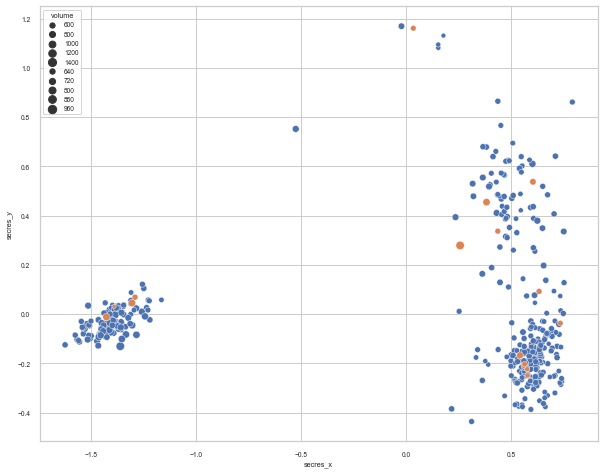

In [16]:
df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'secres_x'
y = 'secres_y'
size='volume'

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=df_prot, size=size)
sns.scatterplot(x=x, y=y, data=df_selected, size=size)
plt.show()

In [143]:
df_prot.sort_values('rfe_ranking')

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_x,vol_y,secres_x,secres_y,volume,surf_area,AUC-ROC,rfe_ranking,Inhib_mass_num,volume.T
4bzd,structure of cdk2 in complex with a benzimidaz...,2014-08-13,1,A,1.83,298,92.953020,3,"[1, 6, 14]","[[14, 14], [38, 43], [149, 162]]",...,0.073413,0.146152,0.603848,0.537193,739.0,519.0,0.66835,1,133956.0,20.089386
2r64,crystal structure of a 3-aminoindazole compoun...,2008-09-09,1,A,2.30,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",...,0.048355,0.049173,0.542051,-0.167388,775.0,517.0,0.65107,2,181476.0,21.575087
3unk,cdk2 in complex with inhibitor yl5-083,2012-01-25,1,A,2.10,298,98.993289,1,[3],"[[37, 39]]",...,0.123780,0.094126,0.734608,-0.037234,654.0,570.0,0.65337,3,85264.0,16.725019
4d1z,cdk2 in complex with a luciferin derivate,2015-03-18,1,A,1.85,298,86.577181,5,"[6, 12, 2, 17, 3]","[[1, 6], [36, 47], [73, 74], [148, 164], [296,...",...,-0.191442,0.103834,0.257242,0.278735,972.0,813.0,0.58665,4,74529.0,30.303961
2iw8,structure of human thr160-phospho cdk2-cyclin ...,2006-09-06,2,A,2.30,294,100.000000,1,[1],"[[299, 299]]",...,-0.054893,0.116523,-1.305247,0.044930,844.0,566.0,0.66958,5,144400.0,24.519616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2vtr,"identification of n-(4-piperidinyl)-4-(2,6-dic...",2008-08-05,1,A,1.89,298,97.315436,1,[8],"[[37, 44]]",...,0.041665,0.006647,0.562372,-0.131280,771.0,496.0,0.61863,398,36100.0,21.408270
2r3n,crystal structure of cyclin-dependent kinase 2...,2008-01-22,1,A,1.63,297,92.281879,3,"[8, 14, 1]","[[36, 43], [149, 162], [177, 177]]",...,0.077959,-0.089652,0.546010,0.421289,567.0,576.0,0.60906,399,103684.0,13.501269
3qzh,cdk2 in complex with inhibitor kvr-1-124,2012-08-08,1,A,1.95,298,98.657718,1,[4],"[[37, 40]]",...,0.106990,0.051550,0.617435,-0.278159,772.0,491.0,0.62076,400,82944.0,21.449934
3wbl,crystal structure of cdk2 in complex with pyra...,2013-10-30,1,A,2.00,298,94.966443,3,"[1, 5, 9]","[[25, 25], [38, 42], [154, 162]]",...,0.093861,-0.036437,0.602820,-0.153700,729.0,549.0,0.61392,401,115600.0,19.683000


In [377]:
%%R -i df_ -w 2.1 -h 3.1 --units in -r 200
library(ggplot2)
library(dplyr)
library(beeswarm)

# bee_data <- beeswarm(value ~ variable, data = df_, pch = 16,
#                      method = 'swarm',
#          pwcol = as.numeric(top_mask))[, c(1, 2, 4, 6)]

# # Plotting with ggplot
# bee_data %>%
#     mutate(colour = ifelse(col == 1, 'red', 'blue')) %>%
#     ggplot(aes(x, y)) +
#     geom_point(size=1.1, alpha=0.6) +
#     scale_x_continuous(breaks = c(1), 
#     labels = c("Protein conformations"), expand = c(0, 1)) +
#     scale_y_continuous(breaks = seq(0.5, 0.7, 0.05), 
#                    limits = c(0.5, 0.7)) + 
#     xlab("") +
#     ylab("AUC-ROC") +
#     geom_hline(yintercept= 0.5, linetype="dashed", color="#888888") +
#     theme(legend.position = 'none', 
#           panel.border = element_rect(colour = "black", fill=NA, size=0.8),
#           panel.background = element_rect(fill = "white",
#                                 colour = "white",
#                                 size = 1, linetype = "solid"),
#           axis.title.y = element_text(size=8),
#           axis.text.y=element_text(size=8, angle=0),
#           panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
#           panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
#           axis.title.x = element_text(size=8),
#           axis.text.x=element_text(size=8, angle=0),
#           panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
#           panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
#           plot.title = element_text(hjust = 0.5, size=11)
#          )



In [18]:
vol_tan_col_mtx

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,400,401
0,1.000000,0.231302,0.216263,0.181614,0.284307,0.271523,0.307066,0.222021,0.230807,0.232679,...,0.214340,0.213218,0.235154,0.233405,0.201510,0.212115,0.216910,0.205896,0.199860,0.240073
1,0.231302,1.000000,0.517937,0.240634,0.335411,0.267805,0.235249,0.366051,0.331662,0.225154,...,0.345172,0.360203,0.315564,0.341395,0.298241,0.290872,0.273860,0.310637,0.275886,0.344585
2,0.216263,0.517937,1.000000,0.230181,0.338922,0.264251,0.233906,0.342465,0.347414,0.219023,...,0.338630,0.343423,0.299455,0.309071,0.298591,0.280649,0.266313,0.309459,0.232385,0.345360
3,0.181614,0.240634,0.230181,1.000000,0.249229,0.161084,0.199744,0.200022,0.213016,0.171313,...,0.282085,0.318556,0.266397,0.238048,0.261200,0.242325,0.225037,0.230665,0.203605,0.295891
4,0.284307,0.335411,0.338922,0.249229,1.000000,0.327539,0.345880,0.265954,0.278131,0.247676,...,0.283669,0.320798,0.362827,0.304510,0.281252,0.321783,0.342537,0.364987,0.253098,0.313211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,0.212115,0.290872,0.280649,0.242325,0.321783,0.238876,0.214727,0.255055,0.282738,0.165758,...,0.314965,0.356178,0.393570,0.421351,0.317547,1.000000,0.475957,0.373539,0.305575,0.348482
398,0.216910,0.273860,0.266313,0.225037,0.342537,0.251167,0.211478,0.246530,0.291520,0.172973,...,0.318407,0.381622,0.402087,0.438104,0.341139,0.475957,1.000000,0.391954,0.313451,0.332205
399,0.205896,0.310637,0.309459,0.230665,0.364987,0.272855,0.265746,0.324725,0.285189,0.204411,...,0.380803,0.376375,0.402739,0.374640,0.391413,0.373539,0.391954,1.000000,0.306141,0.377876
400,0.199860,0.275886,0.232385,0.203605,0.253098,0.205054,0.218395,0.239907,0.266020,0.170553,...,0.263996,0.308341,0.249371,0.352241,0.332472,0.305575,0.313451,0.306141,1.000000,0.261695
